In [3]:
import pandas as pd
import hvplot.pandas
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator, MultipleLocator
import re
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from nltk.text import ConcordanceIndex
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.tokenize import RegexpTokenizer
from nltk import Text
from nltk import ngrams
from datetime import datetime, timedelta
from nltk.stem import SnowballStemmer, WordNetLemmatizer


In [107]:
# Reading in the csv created from the API notebook
csvpath = '/Users/laceymorgan/Desktop/data_job_analysis/google_jobs_3_8_2023.csv'

df = pd.read_csv(csvpath)

In [31]:
df.columns

Index(['job_title', 'company_name', 'job_description', 'via', 'job_id',
       'posted_hours_ago', 'report_run_datetime', 'apply_options', 'rating',
       '#_of_reviews', 'rating_source', 'salary_based_on', 'salary_from',
       'salary_to', 'salary_source', 'my_keywords', 'job_description_summary',
       'sentiment_score', 'salary_mention', 'named_entity_recognition'],
      dtype='object')

In [34]:
df = df.rename(columns={'job title':'job_title', 'company name':'company_name', 'job description':'job_description',
                       'apply options':'apply_options','# of reviews':'#_of_reviews', 'rating source':'rating_source', 
                       'salary based on':'salary_based_on', 'salary from':'salary_from', 'salary to':'salary_to',
                       'salary source':'salary_source'})

In [ ]:
# Dropping the duplicate job_id column
jobs_df = df.drop(columns='job_id.1')

In [9]:
# This function converts a time string to hours so it can be accurately sorted. 

def convert_to_hours(time_str):
    if isinstance(time_str, str):
        if 'hours' in time_str:
            return int(time_str.split()[0])
        elif 'days' in time_str:
            return int(time_str.split()[0]) * 24
        elif 'months' in time_str:
            return int(time_str.split()[0]) * 24 * 30
    return 0

# Applying the function to the 'posted' column for sorting
jobs_df['posted'] = jobs_df['posted'].str.replace(' ago', '').apply(convert_to_hours)

# Renameing the 'posted' column to refelct the change
jobs_df = jobs_df.rename(columns={'posted': 'posted_hours_ago'})

In [10]:
# Sorting the listings by how recently they were listed and then by rating of the hiring company
sort_jobs_df = jobs_df.sort_values(['posted_hours_ago','rating'],ascending=[1,0])

### Visualizations for Daily Searches

The following three visualizations are meant to help give a quick overview of the data collected that day. They show which companies are most frequently listing the jobs searched, the actual titles of the listings and where the jobs are being posted most frequently. 

Graphs are saved to an output file.

In [11]:
# Getting the top companies by # of listings 

top_listers = sort_jobs_df.groupby(sort_jobs_df['company_name']).count()['job_title'].sort_values(ascending=False)[0:15]

top_comps = top_listers.index.tolist()
top_comps_nums = top_listers.values.tolist()

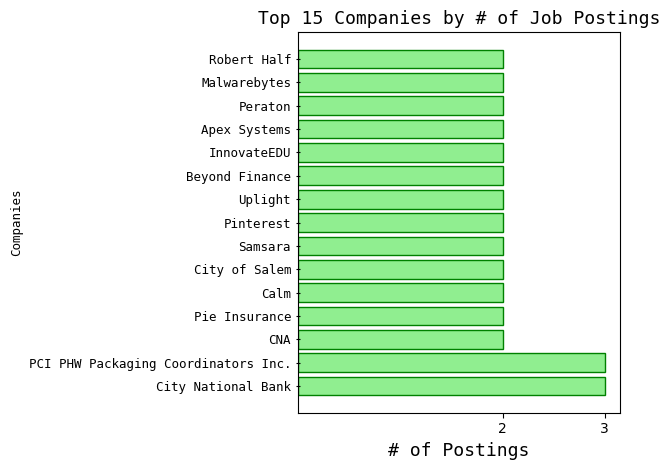

In [12]:

# Create horizontal bar chart for the top companies by # of listings 
plt.barh(top_comps, top_comps_nums, align='center', color='lightgreen', edgecolor='green')

# Set x-axis label, title, and ticks
plt.xlabel('# of Postings', fontdict={'family':'monospace','color':'black','size':13})
plt.title('Top 15 Companies by # of Job Postings', fontdict={'family':'monospace','color':'black','size':13})
plt.xticks(range(int(min(top_comps_nums)), int(max(top_comps_nums))+1))

# Set y-axis label and font
plt.ylabel('Companies', fontdict={'family':'monospace','color':'black','size':9})
plt.tick_params(axis='y', labelsize=9)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties({'family':'monospace','size':9})

# Adjust y-axis ticks
plt.tick_params(axis='y', which='major', direction='inout')

# Save and display plot
plt.tight_layout()
plt.savefig('/Users/laceymorgan/Desktop/data_job_analysis/daily_job_overview_visualizations/top_companies_2_28_2023.png')
plt.show()


In [13]:
# Getting the top job titles by frequency

top_desc = sort_jobs_df.groupby(sort_jobs_df['job_title']).count()['job_description'].sort_values(ascending=False)[0:15]

top_title = top_desc.index.tolist()
top_title_nums = top_desc.values.tolist()

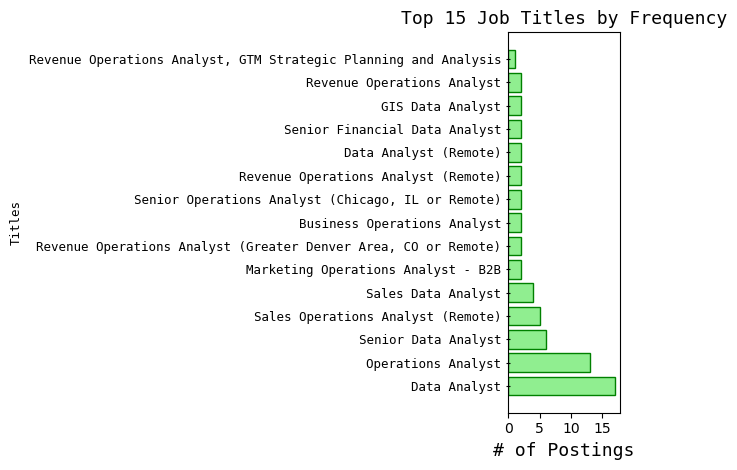

In [16]:

# Create horizontal bar chart for the top job titles by frequency
plt.barh(top_title, top_title_nums, align='center', color='lightgreen', edgecolor='green')

# Set x-axis label, title, and ticks
plt.xlabel('# of Postings', fontdict={'family':'monospace','color':'black','size':13})
plt.title('Top 15 Job Titles by Frequency', fontdict={'family':'monospace','color':'black','size':13})
plt.xticks(range(int(min(top_title_nums)), int(max(top_title_nums))+1))
x_major_locator = MultipleLocator(5)
plt.gca().xaxis.set_major_locator(x_major_locator)

# Set y-axis label and font
plt.ylabel('Titles', fontdict={'family':'monospace','color':'black','size':9})
plt.tick_params(axis='y', labelsize=9)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties({'family':'monospace','size':9})

# Adjust y-axis ticks
plt.tick_params(axis='y', which='major', direction='inout')

# Save and display plot
plt.tight_layout()
# plt.savefig('/Users/laceymorgan/Desktop/data_job_analysis/daily_job_overview_visualizations/top_titles_2_28_2023.png')
plt.show()


In [17]:
# Getting the top listings sites by frequency

top_announce = sort_jobs_df.groupby(sort_jobs_df['via']).count()['job_description'].sort_values(ascending=False)[0:15]

top_announce_name = top_announce.index.tolist()
top_announce_nums = top_announce.values.tolist()


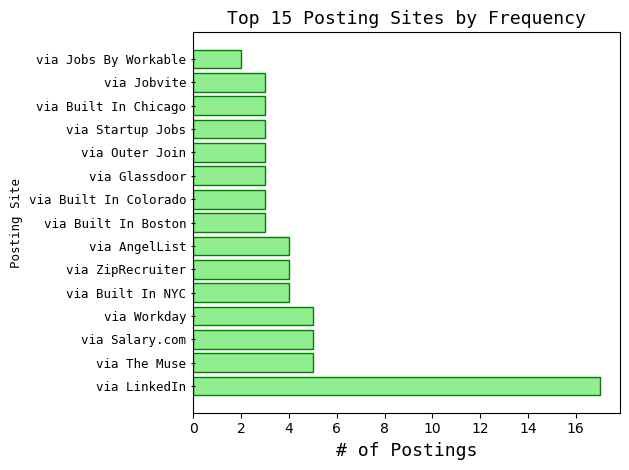

In [19]:

# Create horizontal bar chart for the top job titles by frequency
plt.barh(top_announce_name, top_announce_nums, align='center', color='lightgreen', edgecolor='green')

# Set x-axis label, title, and ticks
plt.xlabel('# of Postings', fontdict={'family':'monospace','color':'black','size':13})
plt.title('Top 15 Posting Sites by Frequency', fontdict={'family':'monospace','color':'black','size':13})
plt.xticks(range(int(min(top_announce_nums)), int(max(top_announce_nums))+1))
x_major_locator = MultipleLocator(2)
plt.gca().xaxis.set_major_locator(x_major_locator)

# Set y-axis label and font
plt.ylabel('Posting Site', fontdict={'family':'monospace','color':'black','size':9})
plt.tick_params(axis='y', labelsize=9)
for label in plt.gca().get_yticklabels():
    label.set_fontproperties({'family':'monospace','size':9})

# Adjust y-axis ticks
plt.tick_params(axis='y', which='major', direction='inout')

# Save and display plot
plt.tight_layout()
# plt.savefig('/Users/laceymorgan/Desktop/data_job_analysis/daily_job_overview_visualizations/top_posting_site_2_28_2023.png')
plt.show()


### Applying NLTK Functions and Methods

The next block of work uses NLTK methods and functions to extract keywords and salary information, perform sentiment analysis and identify named entities all on the job descriptions. These techniques help in generating meaningful insights from the textual data.

In [20]:
# Searching for my list of keywords. If found these are returned from the job description to a new column.
my_keywords = ['python', 'pandas', 'visualization', 'sql', 'tableau']

# Creating a function to identify my keywords in the job descriptions
def identify_my_keywords(description):
    tokens = nltk.word_tokenize(description.lower())
    matches = [word for word in my_keywords if word in tokens]
    return ' '.join(matches) if matches else None

# Applying the identify_keywords function to each job description and create a new column
sort_jobs_df['my_keywords'] = sort_jobs_df['job_description'].apply(identify_my_keywords)

# Sorting to bring the matches to the top
sort_jobs_df.sort_values('my_keywords', ascending=False)


,job_title,company_name,job_description,via,job_id,posted_hours_ago,report_run_datetime,apply_options,rating,#_of_reviews,rating_source,salary_based_on,salary_from,salary_to,salary_source,my_keywords
102,Marketing Data Analyst,Aquent,The Data Analyst offers intelligence and insig...,via Aquent Talent,eyJqb2JfdGl0bGUiOiJNYXJrZXRpbmcgRGF0YSBBbmFseX...,0,2023-03-08 13:07:51,https://aquenttalent.com/talent/jobs/182190?ut...,4.2,947.0,Glassdoor,Based on local employers,46000.0,110000.0,ZipRecruiter,visualization tableau
0,Operations Analyst,Dandelion Energy,Dandelion is looking for an Operations Analyst...,via LinkedIn,eyJqb2JfdGl0bGUiOiJPcGVyYXRpb25zIEFuYWx5c3QiLC...,20,2023-03-08 13:07:00,https://www.linkedin.com/jobs/view/operations-...,4.0,31.0,Glassdoor,NaN,NaN,NaN,NaN,visualization sql tableau
54,Program Operations Management Analyst,Google,Minimum qualifications:\n• Bachelor's degree o...,via Girlboss Jobs,eyJqb2JfdGl0bGUiOiJQcm9ncmFtIE9wZXJhdGlvbnMgTW...,0,2023-03-08 13:07:00,https://jobs.girlboss.com/program-operations-m...,4.4,40866.0,Glassdoor,Based on local employers,49000.0,78000.0,Salary.com,visualization sql tableau
98,Data Analyst V - UALJP,Radus Tek Services,Position:- Data Analyst V - UALJP\n\nLocation:...,via Dice,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgViAtIFVBTE...,48,2023-03-08 13:07:51,https://www.dice.com/job-detail/32430b69-3c7c-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visualization sql tableau
63,Data Analyst,RLA Engineering LLC,Job Title: Data Analyst Department: WS\n\nExpe...,via LinkedIn,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,0,2023-03-08 13:07:51,https://www.linkedin.com/jobs/view/data-analys...,NaN,NaN,NaN,Based on local employers,47000.0,89000.0,Payscale,visualization sql tableau
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,Operations Analyst,Xpansiv,Xpansiv provides the market infrastructure to ...,via AngelList,eyJqb2JfdGl0bGUiOiJPcGVyYXRpb25zIEFuYWx5c3QiLC...,432,2023-03-08 13:07:00,https://angel.co/company/xpansiv/jobs/2582392-...,NaN,NaN,NaN,Based on local employers,43000.0,93000.0,Glassdoor,None
78,Senior Data Analyst - Communications and Publi...,Shopify,The Communications Data team owns data initiat...,via Shopify,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0IC...,456,2023-03-08 13:07:51,https://www.shopify.com/careers/senior-data-an...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
56,Revenue Operations Analyst,"Healthcare Systems and Technologies, LLC",Open Position: Revenue Operations Analyst\n\nR...,"via Healthcare Systems And Technologies, LLC -...",eyJqb2JfdGl0bGUiOiJSZXZlbnVlIE9wZXJhdGlvbnMgQW...,480,2023-03-08 13:07:00,https://hstpathways.applytojob.com/apply/IQK6y...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
59,"Operations Analyst- Trade Support- Hybrid, NYC",Michael Page,About Our Client\n\nAn Asset Management firm l...,via Michael Page,eyJqb2JfdGl0bGUiOiJPcGVyYXRpb25zIEFuYWx5c3QtIF...,624,2023-03-08 13:07:00,https://www.michaelpage.com/job-detail/operati...,3.7,470.0,Indeed,NaN,NaN,NaN,NaN,None


In [103]:
# Creating a job description summary 
# Create a summarizer object
summarizer = LexRankSummarizer()

# Defining the text column that is being summarize
text_column = sort_jobs_df['job_description']

# Looping through each row in the description column and generate a summary
summaries = []
for text in text_column:
    # Creating a parser object and parsing the text
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    # Generating the summary
    summary = summarizer(parser.document, 5)
    
    # Converting the summary to a string and appending it to the summaries list
    summaries.append(" ".join([str(sentence) for sentence in summary]))

# Adding the generated summaries to the DataFrame
sort_jobs_df['job_description_summary'] = summaries


In [108]:
# Preprocessing the job description for sentiment analysis 
# Create instances of stemmer, lemmatizer, and stopwords
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text into words
    words = word_tokenize(text.lower())
    # Remove stop words and punctuations
    words = [w for w in words if w.isalnum() and w not in stop_words]
    # Perform stemming and lemmatization
    words = [stemmer.stem(lemmatizer.lemmatize(w)) for w in words]
    # Join the preprocessed words into a string
    preprocessed_text = ' '.join(words)
    return preprocessed_text

# Apply the preprocessing function to the 'job_description' column
sort_jobs_df['preprocessed_description'] = sort_jobs_df['job_description'].apply(preprocess_text)


In [109]:
# Adding a column with a sentiment score of the job description. 
# Returns a sentiment score between -1 and 1, where negative scores indicate negative sentiment, positive scores 
# indicate positive sentiment, and scores close to 0 indicate neutral sentiment

# Creating an instance of the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to perform sentiment analysis on the job descriptions
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Applying the sentiment analysis function to the 'job description' column  
sort_jobs_df['sentiment_score'] = sort_jobs_df['preprocessed_description'].apply(get_sentiment)


In [25]:
sort_jobs_df.head()

,job_title,company_name,job_description,via,job_id,posted_hours_ago,report_run_datetime,apply_options,rating,#_of_reviews,rating_source,salary_based_on,salary_from,salary_to,salary_source,my_keywords,job_description_summary,preprocessed_description,sentiment_score
105,Data Analyst - Product and Acquisition focus,Wanderu,Wanderu is the leading ground travel search in...,via Openings At Wanderu,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QgLSBQcm9kdW...,0,2023-03-08 13:07:51,https://wanderu.breezy.hr/p/0592386a7c2d-data-...,5.0,9.0,Glassdoor,NaN,NaN,NaN,NaN,python sql,Wanderu is a company that values and promotes ...,wanderu lead ground travel search north americ...,0.9949
71,Data Analyst,Ookla,"We’re Ookla, the company behind Speedtest, Dow...",via Jobs By Workable,eyJqb2JfdGl0bGUiOiJEYXRhIEFuYWx5c3QiLCJodGlkb2...,0,2023-03-08 13:07:51,https://apply.workable.com/ookla/j/96DE997419/...,4.7,20.0,Glassdoor,Based on local employers,54000.0,120000.0,Indeed,python visualization sql,"We’re Ookla, the company behind Speedtest, Dow...",ookla compani behind speedtest downdetector su...,0.9989
108,Senior Data Analyst,Vouch,"About Vouch:\n\nInsurance... sounds slow, old-...",via Y Combinator,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,0,2023-03-08 13:07:51,https://www.ycombinator.com/companies/vouch/jo...,4.6,28.0,Glassdoor,NaN,NaN,NaN,NaN,python sql tableau,"As an insurance company, data is at the core o...",vouch insur sound slow unexcit exact insur bro...,0.9892
54,Program Operations Management Analyst,Google,Minimum qualifications:\n• Bachelor's degree o...,via Girlboss Jobs,eyJqb2JfdGl0bGUiOiJQcm9ncmFtIE9wZXJhdGlvbnMgTW...,0,2023-03-08 13:07:00,https://jobs.girlboss.com/program-operations-m...,4.4,40866.0,Glassdoor,Based on local employers,49000.0,78000.0,Salary.com,visualization sql tableau,• Knowledge of SQL and data visualization tool...,minimum qualif bachelor degre equival practic ...,0.9908
41,Business Operations Analyst,Juniper Networks,Job Title: Business Analyst - Global Service O...,via Salary.com,eyJqb2JfdGl0bGUiOiJCdXNpbmVzcyBPcGVyYXRpb25zIE...,0,2023-03-08 13:07:00,https://www.salary.com/job/juniper-networks/bu...,4.3,3960.0,Glassdoor,Juniper Networks,76000.0,120000.0,Indeed,None,Responsibilities... The primary responsibility...,job titl busi analyst global servic oper respo...,0.9337


In [26]:
# Using the NLTK conconrdance function to look for salary information and write it to a new column

# Converting the 'job description' column of the DataFrame to a list of strings
text = nltk.Text(sort_jobs_df['job_description'].tolist())

# Create a ConcordanceIndex object from the list of strings
# The key argument is used to specify a function that transforms the tokens to lowercase as the concordance function search is case-sensitive
c = ConcordanceIndex(text.tokens, key=lambda s: s.lower())

# An empty list to store the results of the concordance search
salary_matches = []

# Loop over each row of the DataFrame
for i, row in sort_jobs_df.iterrows():
    job_desc = row['job_description']
    # Converting the job description into a list of tokens (words)
    job_desc_text = nltk.Text(job_desc.split())
    # Create a new ConcordanceIndex object for the current job description
    job_desc_c = ConcordanceIndex(job_desc_text.tokens, key=lambda s: s.lower())
    # Searching concordances of the word "salary" in the current job description
    conc_list = job_desc_c.find_concordance('salary')
    # Check if there are any concordances found
    if len(conc_list) > 0:
        # If they are found, take the first one and store it in the 'salary_matches' list
        conc_line = conc_list[0]
        salary_mention = f"{conc_line.right} {conc_line.line}"
        salary_matches.append(salary_mention)
    else:
        # If none are found, store the string 'salary not mentioned' in the 'salary_matches' list
        salary_matches.append('salary not mentioned')

# Creates a new column in the DataFrame to store the results of the concordance search
sort_jobs_df['salary_mention'] = salary_matches


In [27]:
# This is a function to perform named entity recognition on each job description
def get_ner(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    entities = ne_chunk(tagged)
    return entities

# Applying the function to the 'job_description' column and creating a new column
sort_jobs_df['named_entity_recognition'] = sort_jobs_df['job_description'].apply(get_ner)



In [110]:
# Saving the csv
sort_jobs_df.to_csv('google_jobs_3_8_2023.csv', index=False)

In [29]:
# Saving to Excel for processing
sort_jobs_df.to_excel('/Users/laceymorgan/Desktop/data_job_analysis/excel_outputs/google_jobs_3_8_2023.xlsx', index=False)